## Multi-label classification

This is from the lesson plan that I followed to create a working multi-label classification. The information in the csv file which is part of the data information on the Kaggle competition is responsible for creating the mappings of all possible labels against fit data.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.conv_learner import *

In [3]:
PATH = 'data/planet/'

In [4]:
ls {PATH}

test/            train/            train_v2.csv
test-jpg.tar.7z  train-jpg.tar.7z  train_v2.csv.zip


## Multi-label versus single-label classification

In [6]:
from fastai.plots import *

In [7]:
def get_1st(path): return glob(f'{path}/*.*')[0]

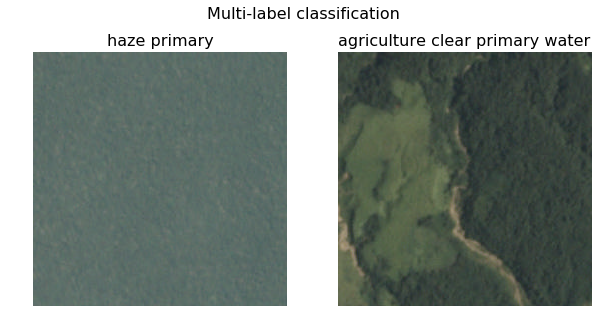

In [8]:
list_paths = [f"{PATH}train/train_0.jpg", f"{PATH}train/train_1.jpg"]
titles=["haze primary", "agriculture clear primary water"]
plots_from_files(list_paths, titles=titles, maintitle="Multi-label classification")

## Multi-label models for Planet dataset

In [9]:
from planet import f2

metrics=[f2]
f_model = resnet34

In [10]:
label_csv = f'{PATH}train_v2.csv'
n = len(list(open(label_csv)))-1
val_idxs = get_cv_idxs(n)

We use a different set of data augmentations for this dataset - we also allow vertical flips, since we don't expect vertical orientation of satellite images to change our classifications. Circles are not like dogs and cats they can show up in any orientation

In [11]:
def get_data(sz):
    tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_top_down, max_zoom=1.05)
    return ImageClassifierData.from_csv(PATH, 'train', label_csv, tfms=tfms,
                    suffix='.jpg', val_idxs=val_idxs, test_name='test')

In [12]:
data = get_data(256)

In [13]:
x,y = next(iter(data.val_dl))

In [14]:
y


    1     0     0  ...      0     0     1
    0     0     0  ...      0     0     0
    1     0     0  ...      0     0     0
       ...          ⋱          ...       
    1     0     0  ...      0     0     1
    0     0     0  ...      0     0     0
    0     0     0  ...      0     0     1
[torch.cuda.FloatTensor of size 64x17 (GPU 0)]

The following are all the labels and whether they exist in the given picture(exist means 1.0)

In [15]:
list(zip(data.classes, y[0]))

[('agriculture', 1.0),
 ('artisinal_mine', 0.0),
 ('bare_ground', 0.0),
 ('blooming', 0.0),
 ('blow_down', 0.0),
 ('clear', 1.0),
 ('cloudy', 0.0),
 ('conventional_mine', 0.0),
 ('cultivation', 0.0),
 ('habitation', 0.0),
 ('haze', 0.0),
 ('partly_cloudy', 0.0),
 ('primary', 1.0),
 ('road', 0.0),
 ('selective_logging', 0.0),
 ('slash_burn', 0.0),
 ('water', 1.0)]

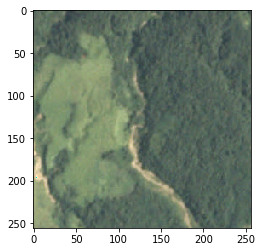

In [22]:
plt.imshow(data.val_ds.denorm(to_np(x))[0]*1.5);

Start at small sizes and then grow the size. One of the tactics to get better work.

In [23]:
sz=64

In [24]:
data = get_data(sz)

The resize is for helping the process move faster if you have very large files. This will go through and create a new jpg of the correct size. other wise the model will try to resize and that will make the process take much longer. (almost the same as the time it take to trian the network!!)

In [25]:
data = data.resize(int(sz*1.3), 'tmp')

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

In [26]:
learn = ConvLearner.pretrained(f_model, data, metrics=metrics)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /home/jperez/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:02<00:00, 32686592.73it/s]


HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   f2                          
    0      0.210803   0.265517   0.821031  



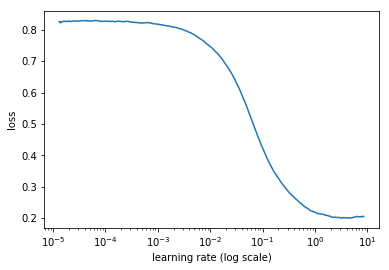

In [27]:
lrf=learn.lr_find()
learn.sched.plot()

In [52]:
lr = 0.21

In [53]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   f2                           
    0      0.088873   0.08526    0.929092  
    1      0.091292   0.093374   0.921503                     
    2      0.083743   0.082285   0.932022                     
    3      0.091341   0.09239    0.924155                     
    4      0.082968   0.084235   0.929832                     
    5      0.080161   0.082741   0.9302                       
    6      0.074466   0.082256   0.932005                     



[0.08225591, 0.9320046805211218]

In [30]:
lrs = np.array([lr/9,lr/3,lr])

remember first train the your new layers and let the foundation stay. New layers start with random numbers and as they are fit the data starts to represent the input. After initial training to "zero" new layers we train all layers together. cycle_mult allows you to extend the iteration for learning rate doubling each iteration shows better results.

In [31]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   f2                          
    0      0.12384    0.112467   0.904729  
    1      0.117341   0.105942   0.910452                    
    2      0.109349   0.102864   0.914216                    
    3      0.111348   0.103618   0.913356                    
    4      0.105853   0.100263   0.91582                     
    5      0.100499   0.099818   0.915782                    
    6      0.102426   0.098318   0.917231                     



[0.09831822, 0.9172306408560972]

In [32]:
learn.save(f'{sz}')

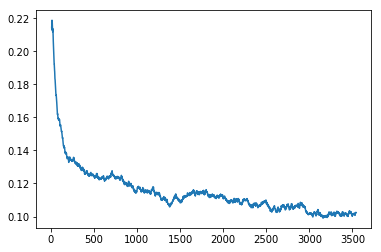

In [33]:
learn.sched.plot_loss()

In [41]:
sz=128

At each level we first run the fit on to affect the output layer.

In [42]:
learn.set_data(get_data(sz))
learn.freeze()
learn.fit(lr, 3, cycle_len=2, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=14), HTML(value='')))

epoch      trn_loss   val_loss   f2                           
    0      0.088231   0.088461   0.926273  
    1      0.089604   0.08806    0.926347                     
    2      0.086336   0.088209   0.926145                     
    3      0.08372    0.087943   0.926212                     
    4      0.090381   0.0874     0.927191                     
    5      0.08666    0.087261   0.927538                     
    6      0.087489   0.087384   0.927762                     
    7      0.088833   0.087091   0.927999                     
    8      0.086011   0.087444   0.927311                     
    9      0.084155   0.087144   0.927809                     
    10     0.086061   0.086941   0.927913                     
    11     0.083878   0.087079   0.92752                      
    12     0.086371   0.08695    0.92808                      
    13     0.085489   0.08695    0.927738                     



[0.086950004, 0.9277382588451479]

Once a round of training is completed on the layer at the given size we run the training again using throttled learning rates for the hidden and input layers. They should not be changing very much. You have to train once the later layers because they start with random values. This allows the values to loose some of the randomness before being handled where the complete model can be affected. THIS REFERS TO THE WEIGHTS in the outer layers.

In [43]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=2, cycle_mult=2)
learn.save(f'{sz}')

HBox(children=(IntProgress(value=0, description='Epoch', max=14), HTML(value='')))

epoch      trn_loss   val_loss   f2                           
    0      0.087616   0.085979   0.927505  
    1      0.082031   0.085117   0.928243                     
    2      0.087613   0.086938   0.928454                     
    3      0.082081   0.084923   0.929207                     
    4      0.079137   0.084489   0.929209                     
    5      0.076914   0.084357   0.929802                     
    6      0.08361    0.087133   0.926585                     
    7      0.082455   0.086448   0.928577                     
    8      0.081228   0.086074   0.929786                     
    9      0.078232   0.085814   0.928776                     
    10     0.076658   0.085934   0.929108                     
    11     0.073783   0.085646   0.92915                      
    12     0.073843   0.086059   0.92909                      
    13     0.072529   0.086053   0.928735                     



In [44]:
sz=256

In [45]:
learn.set_data(get_data(sz))
learn.freeze()
learn.fit(lr, 3, cycle_len=2, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=14), HTML(value='')))

epoch      trn_loss   val_loss   f2                           
    0      0.082871   0.088595   0.925956  
    1      0.083389   0.088068   0.926805                     
    2      0.083326   0.08745    0.927414                     
    3      0.081566   0.087655   0.926966                     
    4      0.081011   0.087299   0.927778                     
    5      0.082395   0.086972   0.92779                      
    6      0.081519   0.08728    0.927801                     
    7      0.08317    0.086899   0.926726                     
    8      0.080163   0.086931   0.927726                     
    9      0.081718   0.086982   0.927109                     
    10     0.080079   0.086791   0.927441                     
    11     0.081682   0.086463   0.928202                     
    12     0.081673   0.086798   0.928196                     
    13     0.078755   0.086526   0.927859                     



[0.086525775, 0.9278592347883247]

In [49]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=2, cycle_mult=2)
learn.save(f'{sz}')

HBox(children=(IntProgress(value=0, description='Epoch', max=14), HTML(value='')))

epoch      trn_loss   val_loss   f2                           
    0      0.07549    0.084351   0.931387  
    1      0.07151    0.083765   0.931118                     
    2      0.075778   0.085458   0.929579                     
    3      0.075434   0.085912   0.929957                     
    4      0.0699     0.084529   0.930038                     
    5      0.068688   0.08517    0.930398                     
    6      0.075802   0.087496   0.92932                      
    7      0.0721     0.087894   0.928036                     
    8      0.070505   0.087296   0.929603                     
    9      0.069082   0.088726   0.928632                     
    10     0.067856   0.087508   0.928898                     
    11     0.06499    0.088576   0.9292                       
    12     0.063365   0.089614   0.929435                     
    13     0.060512   0.088769   0.929321                     



In [50]:
multi_preds, y = learn.TTA()
preds = np.mean(multi_preds, 0)

I was aiming for better than 93.7 no matter how many times I played with learning rate according to finder or adding multiple or cycle not giving me better status. Maybe because of my training sample selection...?

In [51]:
f2(preds,y)

0.9280134535490111

### End